In [ ]:
#import libarary 
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,LeakyReLU,MaxPool2D
from keras.utils import plot_model

In [ ]:
#download data from kaggle and zip data
def download_data(username , password):
    os.environ["KAGGLE_USERNAME"]= username   #username from json file
    os.environ["KAGGLE_KEY"]= password    #password from json file
    !kaggle datasets download -d iarunava/cell-images-for-detecting-malaria  #api download data from kaggle
    ! unzip /content/cell-images-for-detecting-malaria.zip

In [57]:
# call_functin_download_data
username="00" 
password="00"
call_functin_download_data= download_data(username,password)

# **data preprocessing**
       1-convert all images to gray scale
       2-resize the images to be 100 * 100
       3-format the images in x_data,y_data for the training ,testing and validatin



In [78]:
#load image
target_file=["Parasitized" , "Uninfected"] #Folder to be opened
target_high,target_width= 50,50 #Image size
def load_images(Base_path):
  x=[] #data
  y=[]  #index data or target 
  info={} # classes data
  for Folder_name in os.listdir(Base_path): #loop folder in base folder path and load 
    Folder_path=os.path.join(Base_path,Folder_name) 
    if Folder_name not in target_file: 
      continue
    index= target_file.index(Folder_name) #index folder
    info[index]=0
    for image_name in os.listdir(Folder_path): #load image 
      image_path=os.path.join(Folder_path,image_name)
      if image_path.lower().endswith(".png"):
        gray_image=cv2.imread(image_path) #read image
        resized_image=cv2.resize(gray_image,(target_high,target_width)) 
        scaled_image =resized_image.astype("float32")/255.0
        x.append(scaled_image)
        y.append(index)
        info[index]+=1
  x_data=np.array(x,dtype=np.float32)
  x_data=x_data.reshape(len(x),target_high,target_width,3)
  y_data=np.array(y,np.uint8)
  return x_data ,y_data,info

In [79]:
# call_functin_load_image
x,y,info = load_images("/content/cell_images")
x.shape , y.shape , info

((27558, 50, 50, 3), (27558,), {0: 13779, 1: 13779})

## visualize sample from the  data 


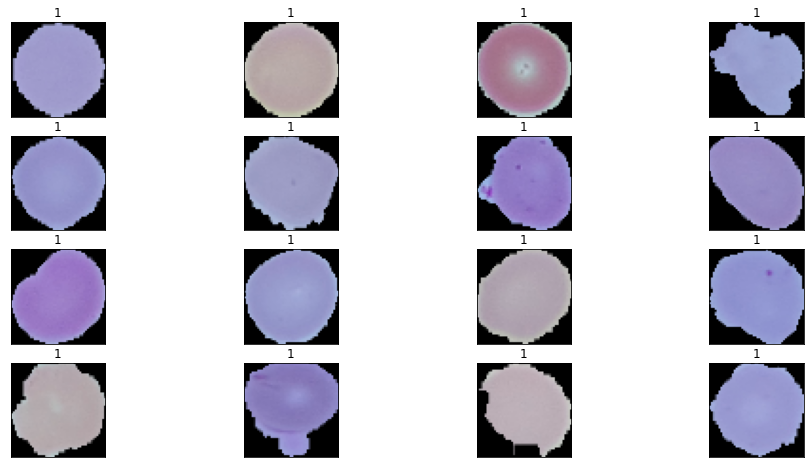

In [82]:
#drow data
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,8))
for i in range(16):
  ax = fig.add_subplot(4, 4, i+1 , xticks=[] , yticks=[])
  ax.imshow(x[i] , cmap="gray")
  ax.set_title(str(y[i]))

## Image Data Augmentation
Data augmentation encompasses a wide range of techniques used to generate “new” training samples from the original ones by applying random jitters and perturbations (but at the same time ensuring that the class labels of the data are not changed).

the Keras ImageDataGenerator class actually works by:


1.   Accepting a batch of images
2.   aking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.)
3.   Replacing the original batch with the new, randomly transformed batch
4.   Training the CNN on this randomly transformed batch (i.e., the original data itself is not used for training).

the following cell is only for illustration
 

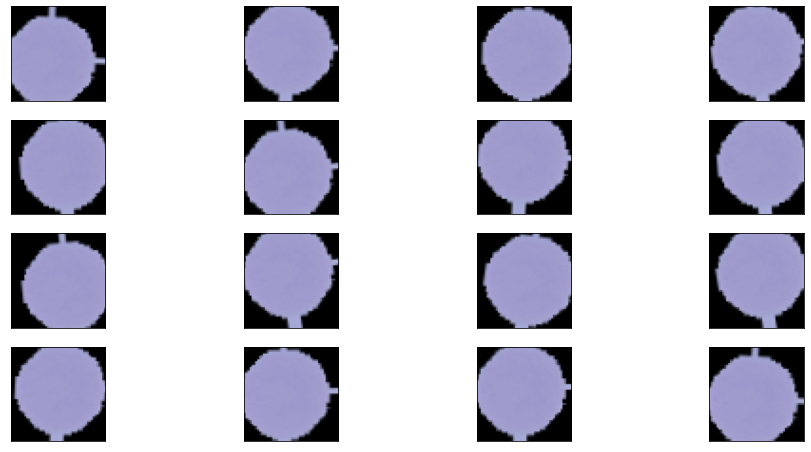

In [96]:
#GeneratorImage
from keras.preprocessing.image import ImageDataGenerator
sample_image = x[0].reshape(1,50,50,3)
gen = ImageDataGenerator(
width_shift_range=0.1,
height_shift_range=0.1,
rotation_range=10
)
fig = plt.figure(figsize=(16,8))
i = 0
for augmented_images in gen.flow(np.array(sample_image), batch_size =1):
    ax = fig.add_subplot(4, 4, i+1 , xticks=[] , yticks=[])
    ax.imshow(augmented_images[0].reshape(50,50,3) , cmap= "gray")
    i += 1
    if i == 16:
      break

In [109]:
data_generator=ImageDataGenerator(zoom_range=0.2,horizontal_flip=True,)
if not os.path.isdir("aug_images"): #creat folder and load data
   os.makedirs("aug_images")
xreshape=x.reshape((27558,50,50,3))
batches=data_generator.flow(xreshape,y,batch_size=32, save_to_dir="aug_images" , save_format="png" )

In [110]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight("balanced" , np.unique(y) , y)
class_weights

array([1., 1.])

## construct base model

In [111]:
#base mode
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(50,50,3)))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 16)        448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 64)         

In [112]:
 model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

## plot model


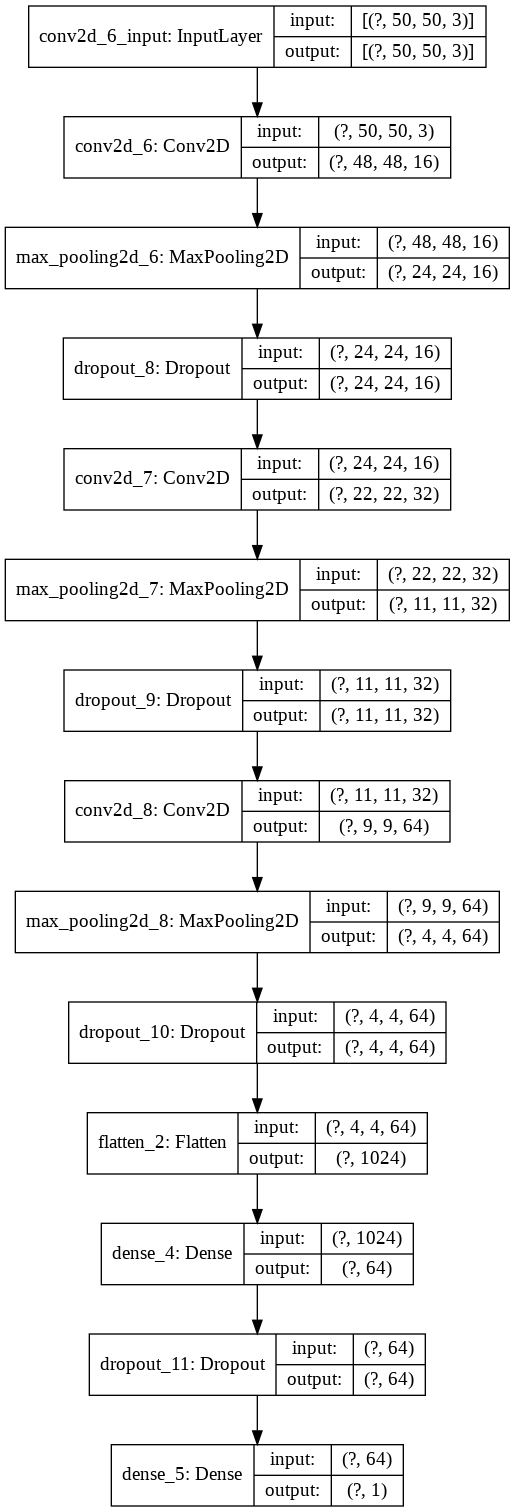

In [113]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [117]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
#Early stop to stop training if val loss not change after 10 epocs
es = EarlyStopping(monitor='val_loss',verbose=1, patience=10)
#save best model during training
mc =  ModelCheckpoint(filepath='best_model.hdf5', monitor='val_loss',
                               verbose=1, save_best_only=True)

callback = [mc,es]
history = model.fit_generator(generator=batches,
                             steps_per_epoch=len(x) // 32, 
                              epochs=20,   
                              shuffle=True,
                              class_weight= {i : class_weights[i] for i in range(2)} ,
                              callbacks = callback)

Epoch 1/20
861/861 [==============================] - 96s 111ms/step - loss: 0.2278 - accuracy: 0.9374
Epoch 2/20
861/861 [==============================] - 96s 111ms/step - loss: 0.2143 - accuracy: 0.9368
Epoch 3/20
861/861 [==============================] - 95s 110ms/step - loss: 0.2060 - accuracy: 0.9380
Epoch 4/20
861/861 [==============================] - 95s 110ms/step - loss: 0.2153 - accuracy: 0.9365
Epoch 5/20
861/861 [==============================] - 95s 110ms/step - loss: 0.2835 - accuracy: 0.9388
Epoch 6/20
861/861 [==============================] - 95s 110ms/step - loss: 0.2142 - accuracy: 0.9399
Epoch 7/20
861/861 [==============================] - 94s 110ms/step - loss: 0.2054 - accuracy: 0.9387
Epoch 8/20
861/861 [==============================] - 95s 110ms/step - loss: 0.2077 - accuracy: 0.9364
Epoch 9/20
861/861 [==============================] - 95s 111ms/step - loss: 0.2146 - accuracy: 0.9400
Epoch 10/20
861/861 [==============================] - 95s 110ms/step - l